# A notebook with the FRB/US model
This notebook is based on the the FRB/US model packages located here (https://www.federalreserve.gov/econres/us-models-package.htm). The packages provides an Eviews (https://www.eviews.com/) implementation. The Eviews modelspecification has been transformed to ModelFlow BusinessLogic specification. 

In this notebook you can make your own experiments by updating variables. Also You can watch some of the capabilities of ModelFlow

FRB/US comes in two flawors: **VAR** in which expectaions are generated by backward looking equations, and **MCE** in which expectation are based on leaded values. 
This notebook implement the **VAR** flavour. 

The tool used is highly experimental and the results are purely for illustration. 

You can run each cell by pressing the run tool or shift+enter
To run all cells use select cell/run all in the menu bar. 

# Import Python libraries

In [1]:
%matplotlib inline

import pandas as pd
from numba import jit

from modelclass import model  
import modelmf

In [2]:
model.modelflow_auto()

# Load the model and the data 
The model and the data has been prepared in a preprocessor step and has been wrapped into one file. 

In [3]:
mfrbus, basedf =  model.modelload('mfrbusvar.json')

res = mfrbus(basedf,'2020q1','2025q4',silent=1,stats=0)

# Run alternative 

In [4]:
# Make a new DataFrame
altdf = basedf.copy()

# Update variables in the dataframe
altdf=altdf.mfcalc('''\
rffintay_aerr = rffintay_aerr - 0.01
dmpex    = 0 
dmprr    = 0
dmptay   = 0
dmptlr   = 0 
dmpintay = 1
dmpalt   = 0
dmpgen   = 0

RFFMIN = 0.0
DMPTRSH = 0
''')

#Run the model 
with model.timer('Solve Frbus'):
    res2 = mfrbus(altdf,ldumpvar = 0,solver='newton',newton_absconv=0.0001)


Solve Frbus took       :         0.2500305176 Seconds


In [5]:
trans = {'XGDPN':'GDP real terms (XGDPN)','RFF':'Federal Funds Rate (RFF)','GFSRPN':'Federal Budget surplus',
        'RFFMIN':'Minimum Fed Funds'}

# Show the results 

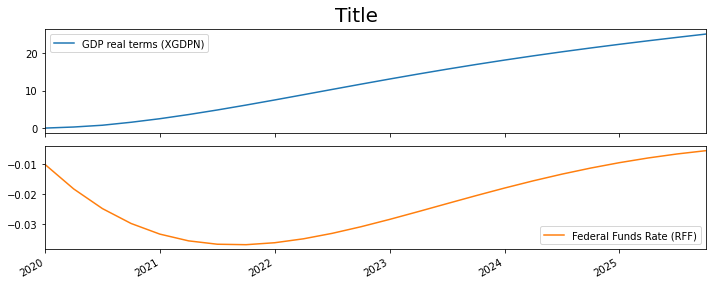

In [6]:
_ = mfrbus['XGDPN RFF'].dif.rename(trans).plot(colrow=1,sharey=0)

# Some interfaces 
. (dot) makes it easy to look at single variable. 

\[ \] (Slice) alows inspection of many variables selected with wildcars

# How is the interest rate determined

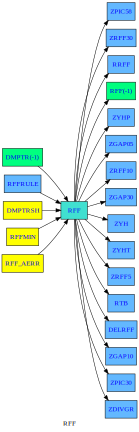

In [7]:
mfrbus.RFF.draw(up=1,down=1,HR=0,svg=1)

# Lets look at how each variable contributes to changes in the equation

In [8]:
with mfrbus.set_smpl('2020q1','2020q4'):
    mfrbus.rffintay.dekomp();

Formula        : FRML <Z> RFFINTAY=.85*RFF(-1)+(1-.85)*(RSTAR+(PICXFE+PICXFE(-1)+PICXFE(-2)+PICXFE(-3))/4+0.5*((PICXFE+PICXFE(-1)+PICXFE(-2)+PICXFE(-3))/4-PITARG)+1.0*XGAP2)+RFFINTAY_AERR   $ 

                    2020Q1     2020Q2     2020Q3     2020Q4
Variable    lag                                            
Base        0     3.153624   3.250023   3.324873   3.378474
Alternative 0     3.143623   3.231767   3.299996   3.348577
Difference  0    -0.010001  -0.018256  -0.024878  -0.029898
Percent     0    -0.317135  -0.561736  -0.748237  -0.884948

 Contributions to differende for  RFFINTAY
                      2020Q1     2020Q2     2020Q3     2020Q4
Variable      lag                                            
RFF           -1    0.000000  -0.008501  -0.015518  -0.021146
RSTAR          0    0.000000  -0.000000   0.000000  -0.000000
PICXFE         0    0.000000   0.000006   0.000018   0.000032
              -1    0.000000  -0.000000   0.000006   0.000018
              -2    0.000000  

# We can look at attribution going back in the model 

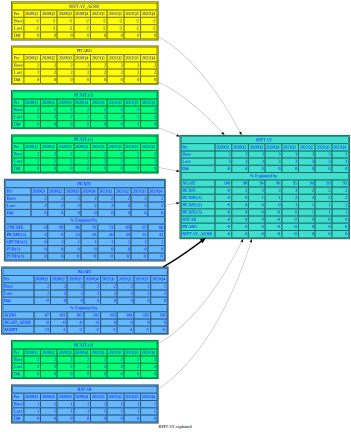

In [9]:
with mfrbus.set_smpl('2020q1','2021q4'):
     mfrbus.rfftay.explain(up=1,svg=1,pdf=0);

# Print out values from the solution 

In [10]:
mfrbus['rffta* rffrule*']

          RFFTAY  RFFTAY_AERR   RFFRULE  RFFRULE_AERR
2020Q1  3.096487    -1.960046  3.143623  2.000000e-10
2020Q2  3.087534    -1.960046  3.231767  3.500000e-09
2020Q3  3.060561    -1.960046  3.299996 -1.000000e-10
2020Q4  3.016356    -1.960046  3.348577 -2.000000e-10
2021Q1  2.962286    -1.960046  3.377909 -5.000000e-10
2021Q2  2.890242    -1.960046  3.389690 -1.200000e-09
2021Q3  2.801868    -1.960046  3.386868 -2.200000e-09
2021Q4  2.701014    -1.960046  3.372661 -4.000000e-09
2022Q1  2.587061    -1.960046  3.350257 -6.833184e-17
2022Q2  2.470148    -1.960046  3.322728  0.000000e+00
2022Q3  2.354614    -1.960046  3.293028 -6.833184e-17
2022Q4  2.244195    -1.960046  3.264097 -0.000000e+00
2023Q1  2.144738    -1.960046  3.238547 -0.000000e+00
2023Q2  2.055024    -1.960046  3.217278 -1.000000e-10
2023Q3  1.974827    -1.960046  3.199490 -2.000000e-10
2023Q4  1.902713    -1.960046  3.184050 -3.000000e-10
2024Q1  1.837055    -1.960046  3.169938 -5.000000e-10
2024Q2  1.776752    -1.96004

# Plot the values from the solution and the baseline

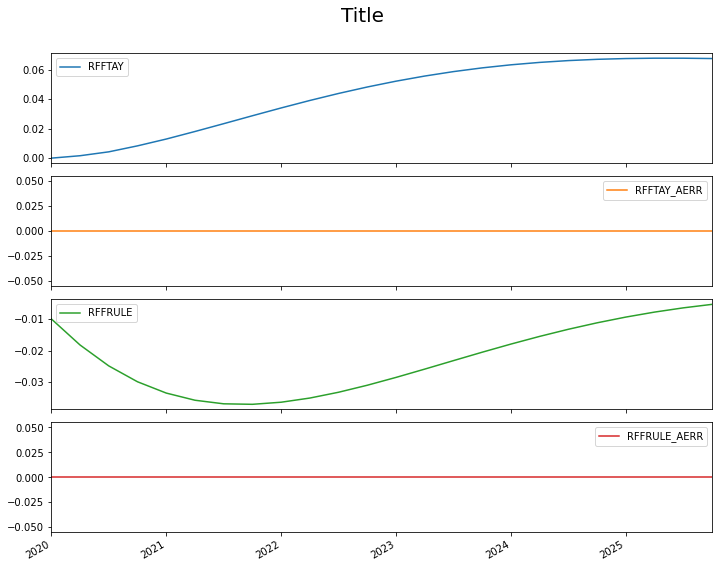

In [11]:
_ = mfrbus['rffta* rffrule*'].dif.plot(colrow=1,sharey=0)

# Look at the model structure 

In [12]:
if 0:  # set to 1 to get a dependency graph
    mfrbus.drawendo(lag=0,title='FRB/US endogeneous interpendencies',svg=1,browser=1)
# you will find the output files in different format in the /graph folder (graph/)

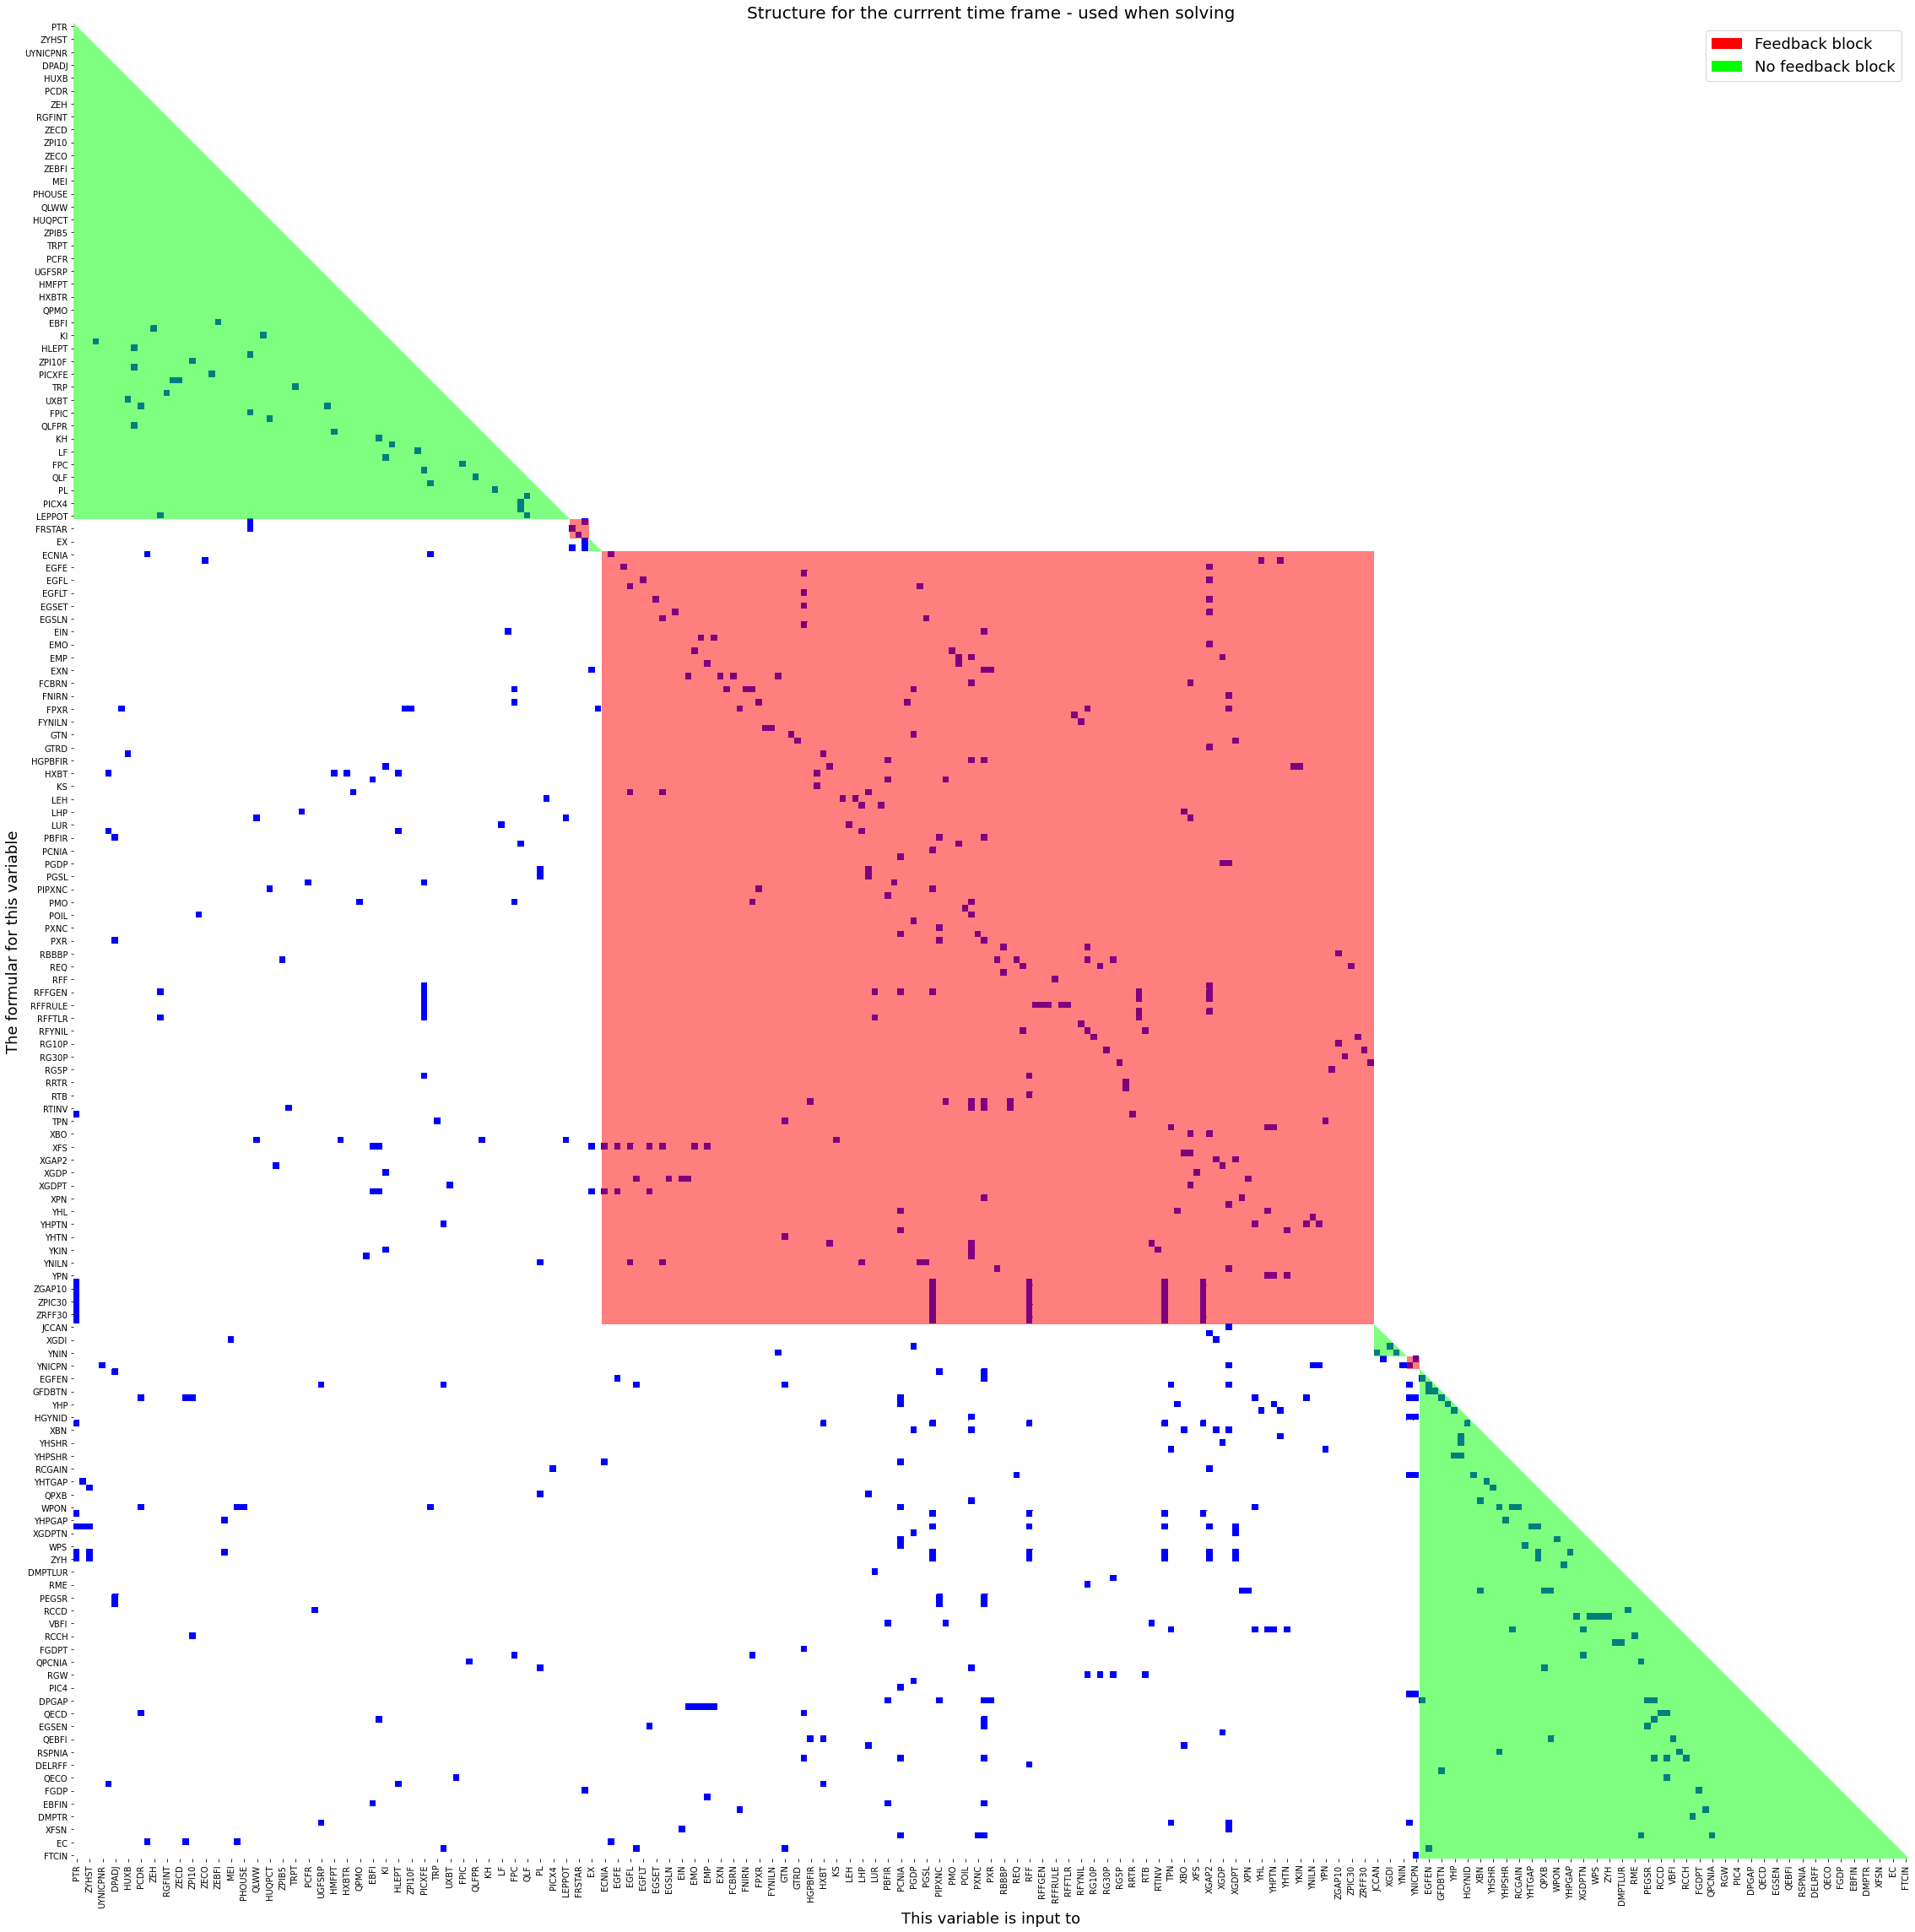

In [13]:
fig   = mfrbus.plotadjacency(size=(40,40),title= 'Structure for the currrent time frame - used when solving')
fig.savefig('graph/FRB-US causality structure current time.pdf')

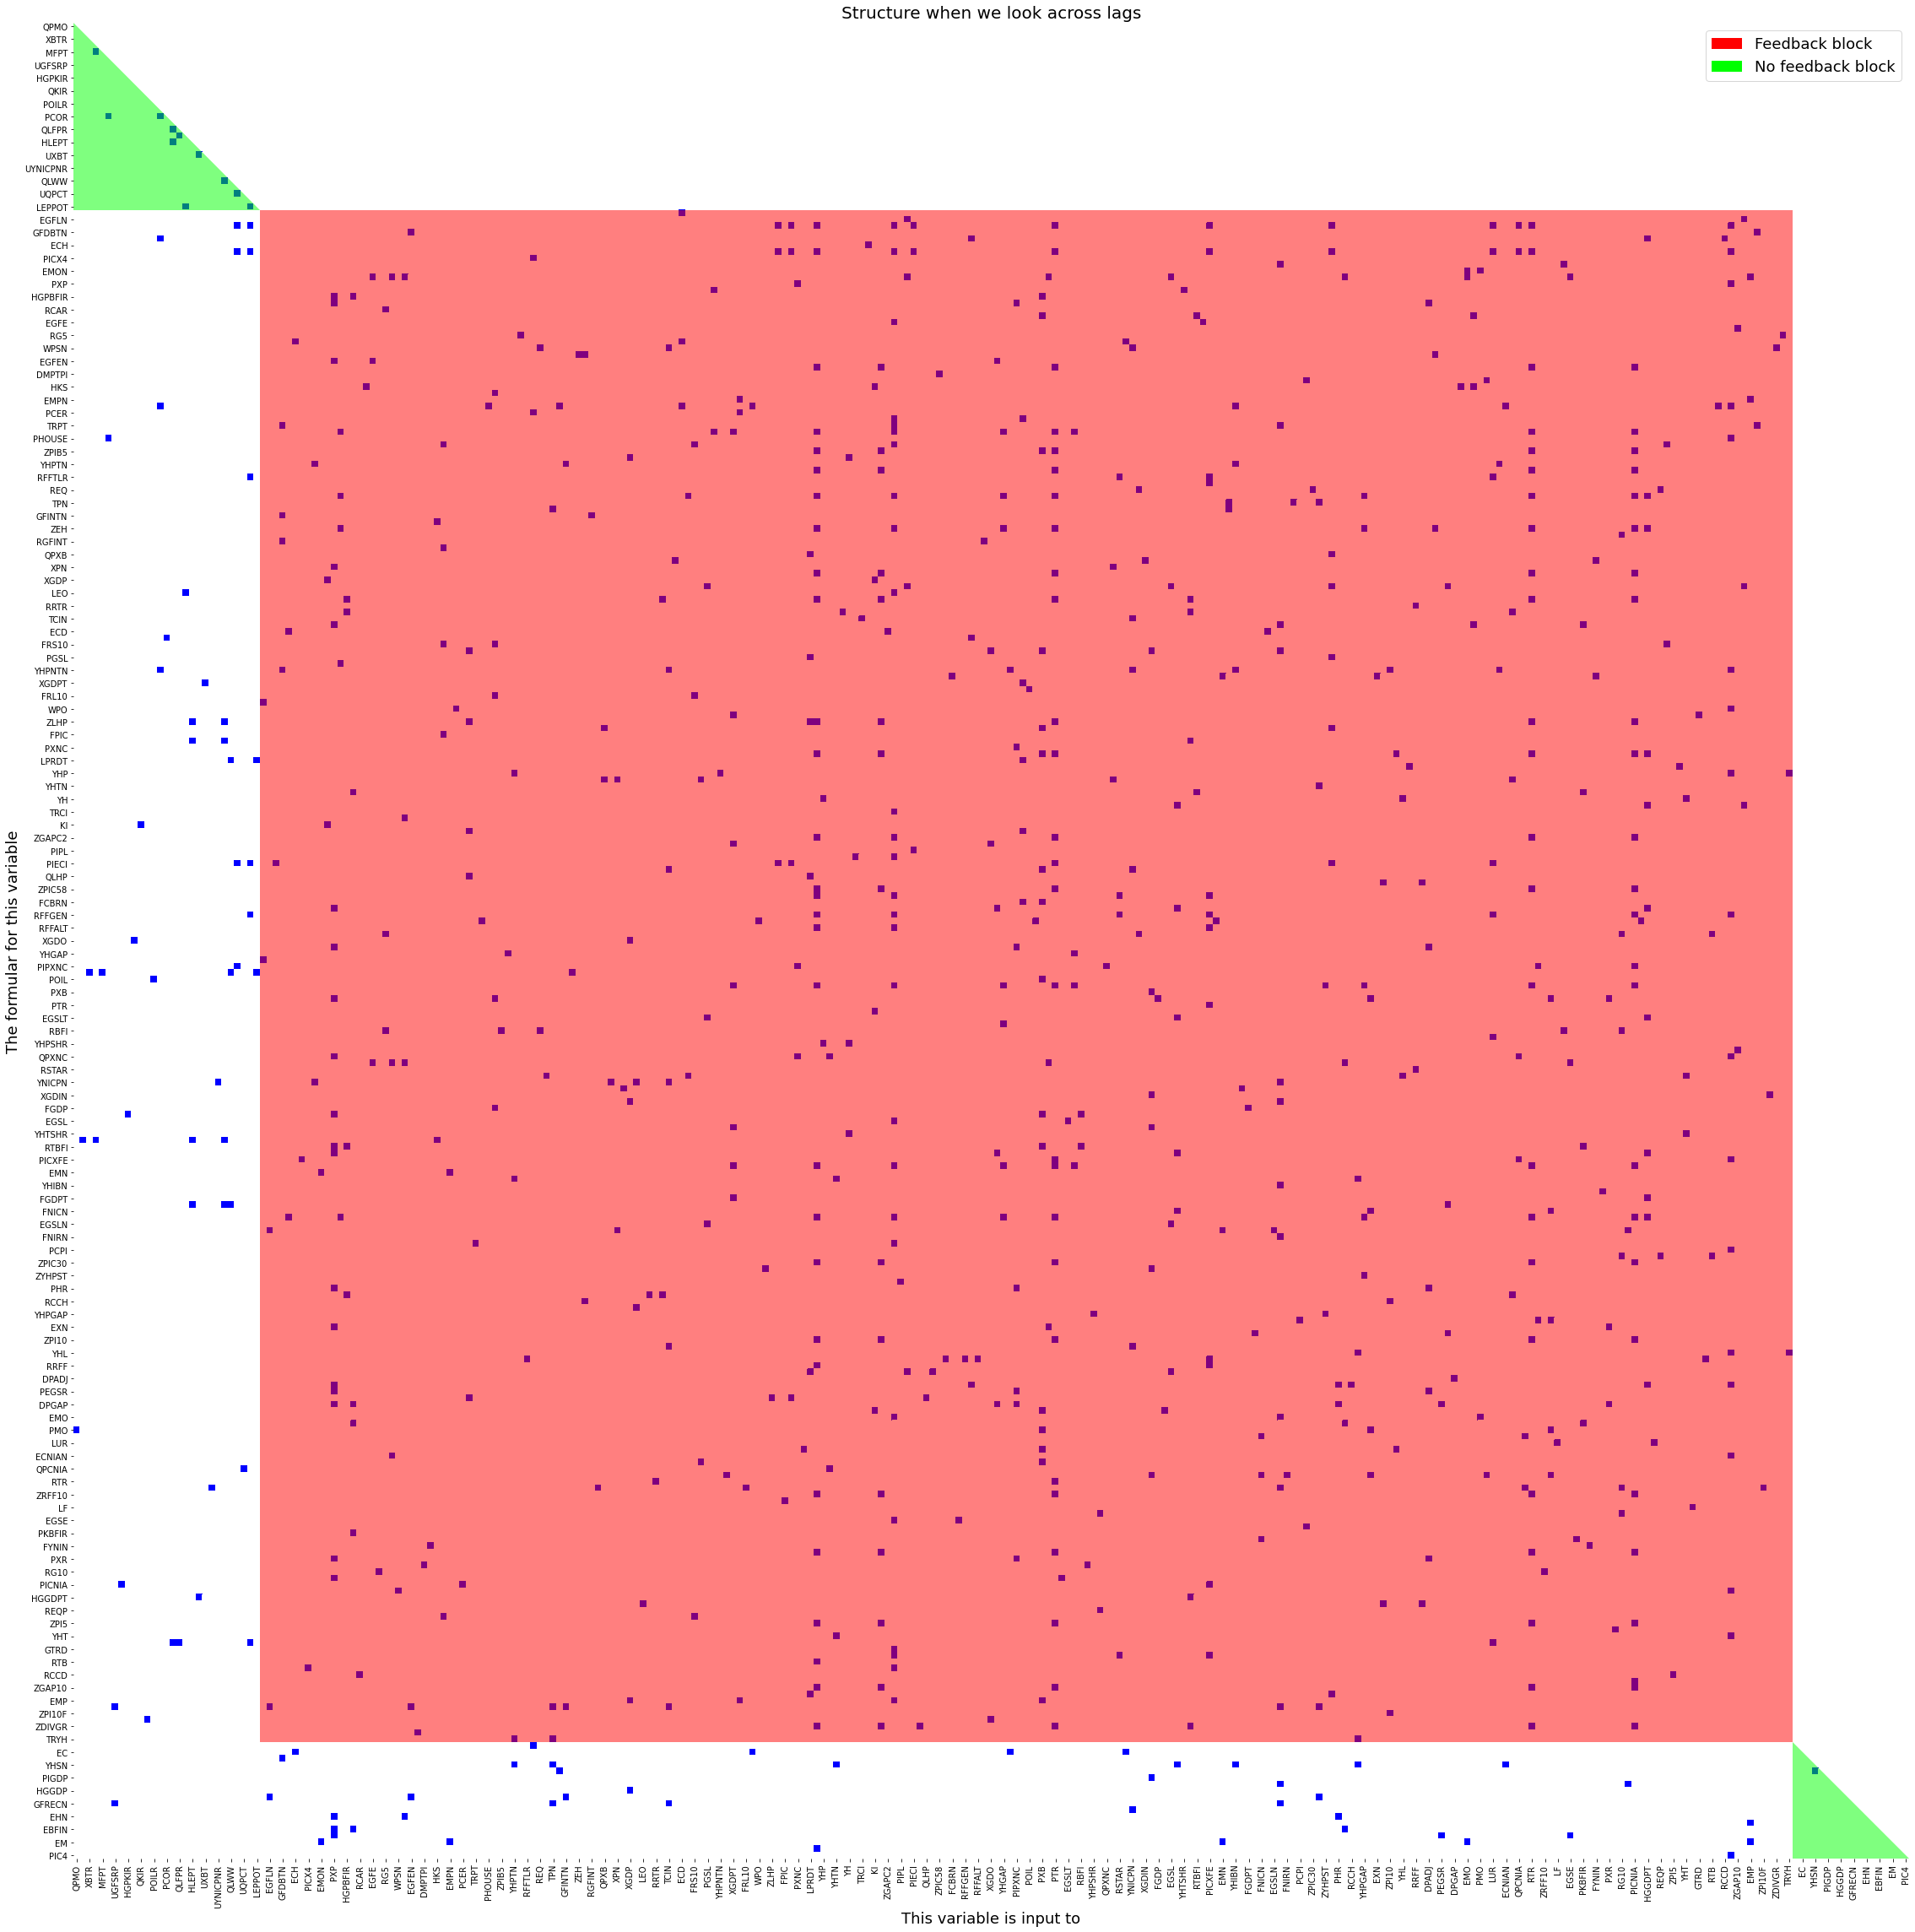

In [14]:
fig   = mfrbus.plotadjacency(size=(40,40),nolag=True,title='Structure when we look across lags')
fig.savefig('graph/FRB-US causality structure across lags.pdf')